### NB: this notebook stems from the main one (with few modifications) to run the heavier computations required to get the dynamics of the center of mass

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import odeint
from matplotlib.animation import FuncAnimation
from scipy import stats
import pandas as pd
from scipy.optimize import curve_fit

In [ ]:
def derivative(X, t, params):
    
    N = params['N']
    A = params['A']
    B = params['B']
    J = params['J']
    K = params['K']
    alpha = params['alpha']
    beta = params['beta']
    gamma = params['gamma']
    v0 = params['v0']
    delta = params['delta']
    dt = params['dt']
    omega = params['omega']
    flag = params['flag']
    
    X_dot = np.zeros((N,4))
    
    diff = X[:, np.newaxis, :3] - X[np.newaxis, :, :3]
    
    #equivalent to:
    #diff = np.zeros((N, N, 3))
    #for i in range(N):
    #    for j in range(N):
    #        diff[i, j, :3] = X[i, :3] - X[j, :3]
    
    #assert np.testing.assert_equal(diff - (X[:, np.newaxis, :3] - X[np.newaxis, :, :3]), np.zeros((N, N, 3)), "hello")
    
    distances = np.linalg.norm(diff[:, :, :2], axis=2) # size (N, N) # matrix of distances 
    np.fill_diagonal(distances, np.inf) # set distance from itself to infinity to force the interaction to 0
    
    phase_diff = diff[:, :, 2] #size (N, N) # matrix of phase differences
    phase_similarity = A + J*np.cos(phase_diff) # F # size (N, N)
    phase_attraction = K*np.sin(phase_diff) # H_att # size (N, N)
    
    x_dot_all = ((diff[:, :, :2].T*(phase_similarity/distances**alpha - B/distances**beta)).T)/N # size (N, N, 2)
    theta_dot_all = ((phase_attraction/distances**gamma)/N).reshape(N, N, 1) # size (N, N, 1)
    X_dot_all = np.concatenate([x_dot_all, theta_dot_all], axis = 2) # size (N, N, 3)
    
    X_dot[:, :3] = np.sum(X_dot_all, axis=0)  # sum over j, size (N, 3)
    
    #add velocity term
    cos_beta = np.cos(X[:, 3])
    sin_beta = np.sin(X[:, 3])

    n_hat = np.column_stack((cos_beta, sin_beta)) #size (N, 2)
    X_dot[:, :2] += v0 * n_hat
    X_dot[:, 2] += omega
    
    #omega from cauchy distribution
    #cauchy distribution: location-scale family
    #if you draw a sample x from Cauchy(0, 1), just shift it by x_0 and multiply with gamma and
    #x' = x_0 + gamma * x will be distributed according to Cauchy(x_0, gamma)
    
    
    #calculate beta dot
    beta_dot = np.zeros(N)
    for i in range(N):
        beta_dot[i] = -X[i, 3] # size(1,)
        neighbors = np.where(distances[i] < delta)[0]
        num_neighbors = len(neighbors)
        if(num_neighbors > 0):
            beta_dot[i] += (np.sum(X[neighbors, 3]) / num_neighbors)
    
    X_dot[:, 3] = beta_dot


    
    return X_dot

In [ ]:
def generate_noise(params):
    
    N = params['N']
    Dx = params['Dx']
    Dy = params['Dy']
    Dtheta = params['Dtheta']
    Dbeta = params['Dbeta']
    dt = params['dt']
    
    #add noise term
    noise = np.zeros((N,4))
    noise[:, :2] = np.random.normal(scale=[np.sqrt(2*Dx*dt), np.sqrt(2*Dy*dt)], size=(N, 2))
    noise[:, 2] = np.random.normal(scale=np.sqrt(2*Dtheta*dt), size=N)
    noise[:, 3] = np.random.normal(scale=np.sqrt(2*Dbeta*dt), size=N)
    
    return noise

In [ ]:
def generate_S(params):
    
    N = params['N']
    Dx = params['Dx']
    Dy = params['Dy']
    Dtheta = params['Dtheta']
    Dbeta = params['Dbeta']
    dt = params['dt']
    
    S = (np.random.binomial(size=(N,4), n=1, p= 0.5)*2.0 - 1.0)*[np.sqrt(2*Dx*dt),
                                                                 np.sqrt(2*Dy*dt),
                                                                 np.sqrt(2*Dtheta*dt),
                                                                 np.sqrt(2*Dbeta*dt)]
    
    return S

In [ ]:
def generate_data_S(X0, params): # runge kutta 2nd order, consider also S term
    
    N = params['N']
    Dx = params['Dx']
    Dy = params['Dy']
    Dtheta = params['Dtheta']
    Dbeta = params['Dbeta']
    dt = params['dt']
    n_iter = params['n_iter']
    
    history_X = [X0]
    
    for t in tqdm(range(1, n_iter)):
        x = history_X[-1]
        F1 = derivative(x, t*dt, params)
        F2 = derivative(x + dt*F1 + generate_noise(params) - generate_S(params), t*dt, params)
        history_X.append(x + (F1+F2)*dt/2 + generate_noise(params) + generate_S(params))
    
    return history_X

In [ ]:
def generate_data_heun(X0, params): # runge kutta 2nd order

    N = params['N']
    Dx = params['Dx']
    Dy = params['Dy']
    Dtheta = params['Dtheta']
    Dbeta = params['Dbeta']
    dt = params['dt']
    n_iter = params['n_iter']
    
    history_X = [X0]
    
    for t in tqdm(range(1, n_iter)):
        x = history_X[-1]
        F1 = derivative(x, t*dt, params)
        F2 = derivative(x + dt*F1 + generate_noise(params), t*dt, params)
        history_X.append(x + (F1+F2)*dt/2 + generate_noise(params))
    
    return history_X

In [ ]:
def angle_transf(v_theta):
    v_theta = v_theta%(2*np.pi)
    out = np.where(v_theta > np.pi, v_theta - 2*np.pi, v_theta)
    return out

In [ ]:
def plot_swarm(X, title):
    
    plt.figure(figsize=(10, 8))
    plt.xlabel(r"$x$", fontsize=15)
    plt.ylabel(r"$y$", fontsize=15)
    plt.title(title, fontsize=20)
    #plt.xlim(-2, 2)
    #plt.ylim(-2, 2)

    # Calculate arrow properties
    arrow_length = 0.2  # Length of the arrow
    arrow_color = angle_transf(X[:, 2]) # Color based on phase (theta)

    # Create scatter plot to define the mappable
    scatter = plt.scatter(X[:, 0], X[:, 1], c=arrow_color, cmap='rainbow', vmin=-np.pi, vmax=np.pi)

    # Plot arrows
    for x, y, beta, color in zip(X[:, 0], X[:, 1], X[:, 3], arrow_color):
        dx = arrow_length * np.cos(beta)
        dy = arrow_length * np.sin(beta)
        plt.arrow(x, y, dx, dy, color=scatter.to_rgba(color), alpha=0.8)

    plt.colorbar(label=r"$\theta \ mod \ (2 \pi)$")
    plt.show()

In [6]:
#general parameters, not changed when model is fixed
#parameters for the model, can be changed to retrieve different phases
#noise terms
#number of swarmalators

params = {
    'N': 100,
    'A': 1,
    'B': 1,
    'J': 0.5,
    'K': -0.1,
    'alpha': 1,
    'beta': 2,
    'gamma': 1,
    'v0': 0.001,
    'delta': 0.5,
    'Dx': 0,
    'Dy': 0,
    'Dtheta': 0.01,
    'Dbeta': 0.01,
    'sigma': 0.01,
    'dt': 0.1,
    'n_iter': 50000,
    'omega': None,
    'folder_npy': "np arrays/alignment/",
    'folder_video': "video/alignment/",
    'flag': 'const',
    'seed': 37,
    'T' : 5000
}

np.random.seed(params['seed'])

num_points = 11  # Adjust the number of points as needed
power = 2  # Adjust the power value based on your preference

# Generate points inversely proportional to x using a power law
x_values = np.linspace(0, 1, num_points)
pts = (x_values) ** power

# load data/save animation
LOAD = False
SAVE_NP = True
SAVE_VIDEO = False

# folders and titles
name_video = params['folder_video'] + "J={}_K={}_N={}_Db={}_dt={}_T={}".format(params['J'], params['K'], params['N'], params['Dbeta'], params['dt'], params['T']) + "_aligned.mp4"

In [ ]:
# Values of K to consider
K_values = [-0.1, -1.0]  # Add more values if needed

seed = params['seed']
t = params['n_iter'] - 1

# Generate 5 different initial conditions
initial_conditions = []
omegas = []
for trial_seed in range(5):
    np.random.seed(seed + trial_seed)
    x0 = np.random.uniform(-2, 2, size = (params['N'], 2))
    theta0 = np.random.uniform(-np.pi, np.pi, size = (params['N'], 1))
    omega = stats.cauchy.rvs(scale=params['sigma'], size = params['N'])
    beta0 = np.random.uniform(-np.pi, np.pi, size = (params['N'], 1))
    X0 = np.concatenate([x0, theta0, beta0], axis = 1)
    initial_conditions.append(X0) # list of 5 np arrays that are initial condition for a given seed.
    omegas.append(omega)

In [ ]:
# Loop over the 5 sets of initial conditions
for trial_seed, (X0, omega) in enumerate(zip(initial_conditions, omegas)):
    if trial_seed < 3.5:
        continue
        
    pos_0 = X0[:, :2]
    cm_0 = np.mean(pos_0, axis=0)

    print("analyze trial = ", trial_seed)
    
    for K in K_values:
        
        print("analyze K = ", K)
        params['K'] = K

        
        for Dbeta in pts:
            print("analyze Db = ", Dbeta)
            params['Dbeta'] = Dbeta


            np.random.seed(seed + trial_seed)  # Vary the seed for each trial

            params['seed'] = seed + trial_seed
            params['omega'] = omegas[trial_seed]



            if not LOAD: 
                trial = generate_data_heun(X0, params)
                trial = np.stack(trial)
            else:
                trial = np.load(folder_npy + "J={}_K={}_N={}_Db={}_dt={}_T={}_trial{}".format(params['J'], params['K'], params['N'], params['Dbeta'], params['dt'], params['T'], trial_seed) +params['flag'] + "_aligned_final.npy")

            if SAVE_NP:
                # Update the file names to include trial_seed, Dbeta, and K
                
                final_filename = params['folder_npy'] + "J={}_K={}_N={}_Db={}_dt={}_T={}_trial{}".format(params['J'], params['K'], params['N'], params['Dbeta'], params['dt'], params['T'], trial_seed) +params['flag'] + "_aligned_final.npy"

                np.save(final_filename, trial[t])

            pos_f = trial[t][:, :2]
            cm_f = np.mean(pos_f, axis=0)
            norm_cm = np.linalg.norm(cm_f - cm_0)
            cm_d = np.hstack((cm_f, cm_0, norm_cm))

            # Append the trial information to the DataFrame
            trial_data = trial_data.append({'trial_seed': trial_seed, 'Dbeta': Dbeta, 'K': K,
                                            'cm_f_x': cm_f[0], 'cm_f_y': cm_f[1],
                                            'cm_0_x': cm_0[0], 'cm_0_y': cm_0[1],
                                            'norm_cm': norm_cm}, ignore_index=True)
            


# Save the DataFrame to a CSV file
trial_data.to_csv('trial_data.csv', index=False)

In [ ]:
#a = np.load(params['folder_npy']+"vecchi/"+"J=0.5_K=-0.1_N=100_Db=0.25_dt=0.1_T=5000_trial0const_aligned_final.npy")
#b = np.load(params['folder_npy']+"J=0.5_K=-0.1_N=100_Db=0.25_dt=0.1_T=5000_trial=0_const_aligned_final.npy")

# Fit of the plots

need libraries and parameters to run this

In [4]:
trial_data = pd.DataFrame(columns=['trial_seed', 'Dbeta', 'K', 'cm_f_x', 'cm_f_y', 'cm_0_x', 'cm_0_y', 'norm_cm'])

In [7]:
K_values = [-0.1, -1.0]
for trial_seed in range(5): # importing all the data from the npy arrays
    for K in K_values:
        for Dbeta in pts: 
            trial = np.load(params['folder_npy'] + "J={}_K={}_N={}_Db={}_dt={}_T={}_trial{}".format(params['J'], K, params['N'], Dbeta, params['dt'], params['T'], trial_seed) +params['flag'] + "_aligned_final.npy")
            initial = np.load(params['folder_npy'] + "initial_conditions/" +"initial_conditions={}.npy".format(trial_seed))
            pos_0 = initial[:, :2]
            pos_f = trial[:, :2]
            cm_0 = np.mean(pos_0, axis=0)
            cm_f = np.mean(pos_f, axis=0)
            norm_cm = np.linalg.norm(cm_f - cm_0)
            cm_d = np.hstack((cm_f, cm_0, norm_cm))
            trial_data = trial_data.append({'trial_seed': trial_seed, 'Dbeta': Dbeta, 'K': K,
                                            'cm_f_x': cm_f[0], 'cm_f_y': cm_f[1],
                                            'cm_0_x': cm_0[0], 'cm_0_y': cm_0[1],
                                            'norm_cm': norm_cm}, ignore_index=True)

In [8]:
trial_data

,trial_seed,Dbeta,K,cm_f_x,cm_f_y,cm_0_x,cm_0_y,norm_cm
0,0.0,0.00,-0.1,4.911788,1.311544,0.096129,-0.029050,4.998776
1,0.0,0.01,-0.1,4.898524,0.377972,0.096129,-0.029050,4.819612
2,0.0,0.04,-0.1,4.447171,0.404945,0.096129,-0.029050,4.372633
3,0.0,0.09,-0.1,3.086882,-1.911922,0.096129,-0.029050,3.534093
4,0.0,0.16,-0.1,0.618427,-2.032075,0.096129,-0.029050,2.070002
...,...,...,...,...,...,...,...,...
105,4.0,0.36,-1.0,-0.217391,0.162894,-0.216638,0.009505,0.153391
106,4.0,0.49,-1.0,0.015742,-0.067161,-0.216638,0.009505,0.244700
107,4.0,0.64,-1.0,-0.267946,0.326553,-0.216638,0.009505,0.321173
108,4.0,0.81,-1.0,-0.507658,-0.002126,-0.216638,0.009505,0.291253


In [9]:
trial_data_0 = trial_data[trial_data['K'] == -0.1] # 0 is the case when K = -0.1
trial_data_1 = trial_data[trial_data['K'] == -1.0] # 1 is the case when K = -1.0

In [10]:
trial_data_0

,trial_seed,Dbeta,K,cm_f_x,cm_f_y,cm_0_x,cm_0_y,norm_cm
0,0.0,0.00,-0.1,4.911788,1.311544,0.096129,-0.029050,4.998776
1,0.0,0.01,-0.1,4.898524,0.377972,0.096129,-0.029050,4.819612
2,0.0,0.04,-0.1,4.447171,0.404945,0.096129,-0.029050,4.372633
3,0.0,0.09,-0.1,3.086882,-1.911922,0.096129,-0.029050,3.534093
4,0.0,0.16,-0.1,0.618427,-2.032075,0.096129,-0.029050,2.070002
5,0.0,0.25,-0.1,-0.240550,-1.355864,0.096129,-0.029050,1.368864
6,0.0,0.36,-0.1,0.164968,-1.237728,0.096129,-0.029050,1.210637
7,0.0,0.49,-0.1,0.262185,-0.730358,0.096129,-0.029050,0.720700
8,0.0,0.64,-0.1,0.588927,-0.648222,0.096129,-0.029050,0.791343
9,0.0,0.81,-0.1,0.487702,-0.387766,0.096129,-0.029050,0.531043


## Exponential fit using linear fit in log scale

In [11]:
dist_0 = np.zeros(11)
std_0 = np.zeros(11)
for i, Dbeta in enumerate(pts):
    dist_0[i] = trial_data_0[trial_data_0['Dbeta'] == Dbeta].mean()['norm_cm'] # average distance
    std_0[i] = trial_data_0[trial_data_0['Dbeta'] == Dbeta].std()['norm_cm'] # std of the distances
    
a_0, b_0 = np.polyfit(pts, np.log(dist_0), 1) # linear fit with logscale on y axis

    
dist_1 = np.zeros(11)
std_1 = np.zeros(11)
for i, Dbeta in enumerate(pts):
    dist_1[i] = trial_data_1[trial_data_1['Dbeta'] == Dbeta].mean()['norm_cm']
    std_1[i] = trial_data_1[trial_data_1['Dbeta'] == Dbeta].std()['norm_cm']
    
a_1, b_1 = np.polyfit(pts, np.log(dist_1), 1) 

In [12]:
# exponents of the two fits
print(a_0)
print(a_1)

-2.204474864980401
-2.280646089948673


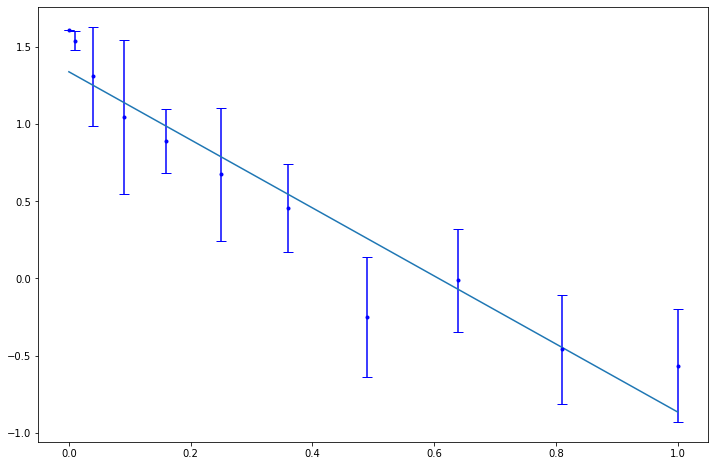

In [13]:
plt.figure(figsize = (12, 8))
plt.errorbar(pts, np.log(dist_0), std_0/dist_0, fmt = '.', c = 'b', capsize = 5)
plt.plot(pts, a_0*pts + b_0)

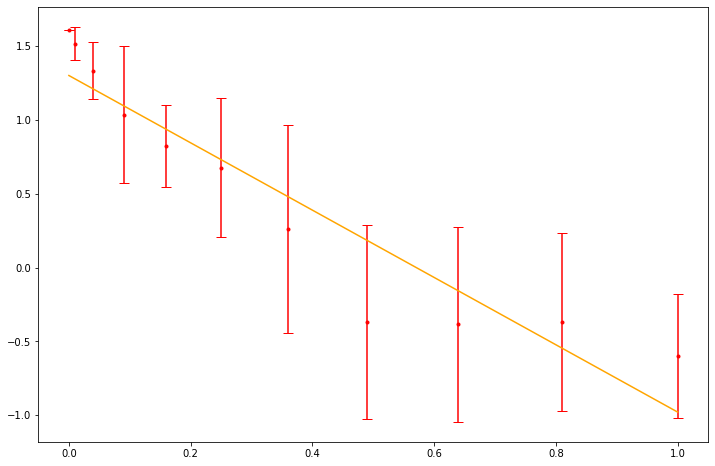

In [14]:
plt.figure(figsize = (12, 8))
plt.errorbar(pts, np.log(dist_1), std_1/dist_1, fmt = '.', c = 'r', capsize = 5)
plt.plot(pts, a_1*pts + b_1, c = 'orange')

## Exponential and Power law fits

In [15]:
def f_model_hyper(x, alpha, b, c):  # function to fit

    # Check if x is close to zero and avoid division by zero
    epsilon = 1e-8  # A small positive value to avoid division by zero
    x = np.where(np.abs(x) < epsilon, epsilon, x)
    
    return b/(1 + c * x**alpha)
    #return c*np.exp(-alpha*x)


popt0, pcov0 = curve_fit(f_model_hyper, pts, dist_0, sigma = std_0)
popt1, pcov1 = curve_fit(f_model_hyper, pts, dist_1, sigma = std_1)
print(popt0)
print(popt1)

[1.05613343 4.99880548 8.03211287]
[1.03172857 4.99880642 8.76105893]


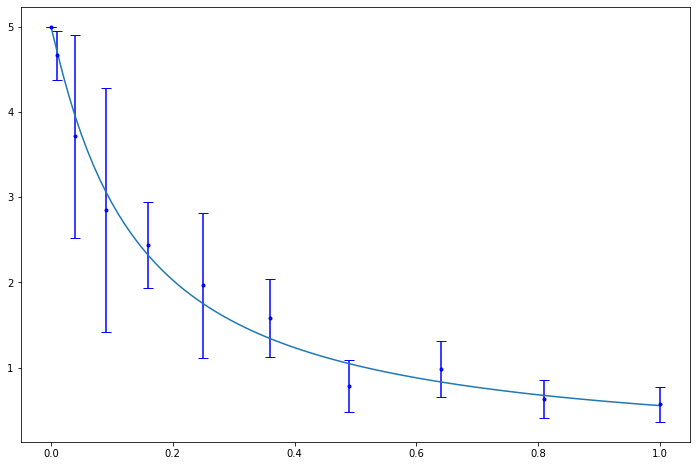

In [21]:
xplot = np.linspace(0, 1, 101)
plt.figure(figsize = (12, 8))
plt.errorbar(pts, dist_0, std_0, fmt = '.', c = 'b', capsize = 5)
plt.plot(xplot, f_model_hyper(xplot, *popt0))

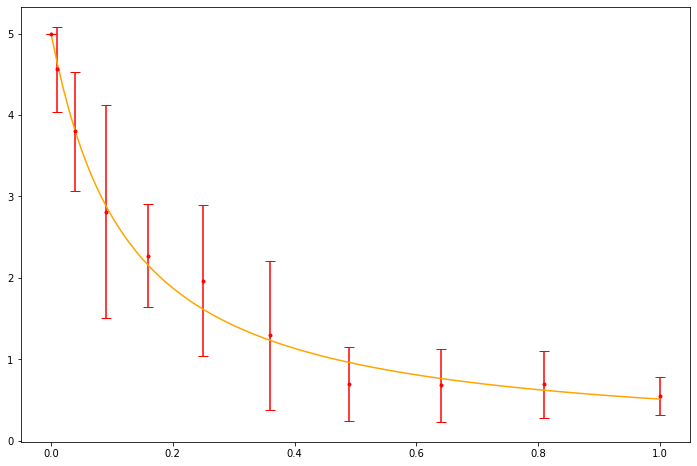

In [16]:
xplot = np.linspace(0, 1, 101)
plt.figure(figsize = (12, 8))
plt.errorbar(pts, dist_1, std_1, fmt = '.', c = 'r', capsize = 5)
plt.plot(xplot, f_model_hyper(xplot, *popt1), c = 'orange')

In [22]:
# Compute the predicted values using the fitted model for both popt0 and popt1
predicted_values_0 = f_model_hyper(pts, *popt0)
predicted_values_1 = f_model_hyper(pts, *popt1)

# Compute the residuals
residuals_0 = dist_0 - predicted_values_0
residuals_1 = dist_1 - predicted_values_1

# Square the residuals
squared_residuals_0 = residuals_0 ** 2
squared_residuals_1 = residuals_1 ** 2

# Compute the sum of squared residuals
sum_squared_residuals_0 = np.sum(squared_residuals_0)
sum_squared_residuals_1 = np.sum(squared_residuals_1)

print("Sum of squared residuals for K = -0.1:", sum_squared_residuals_0)
print("Sum of squared residuals for K = -1.0:", sum_squared_residuals_1)

Sum of squared residuals for K = -0.1: 0.31744435753119005
Sum of squared residuals for K = -1.0: 0.24275148651366923


In [23]:
def f_model_exp(x, alpha, c):  # function to fit
    return c*np.exp(-alpha*x)

exp_popt0, exp_pcov0 = curve_fit(f_model_exp, pts, dist_0, sigma = std_0)
exp_popt1, exp_pcov1 = curve_fit(f_model_exp, pts, dist_1, sigma = std_1)
print(exp_popt0)
print(exp_popt1)

[3.02205005 4.99880511]
[3.38493024 4.99880601]


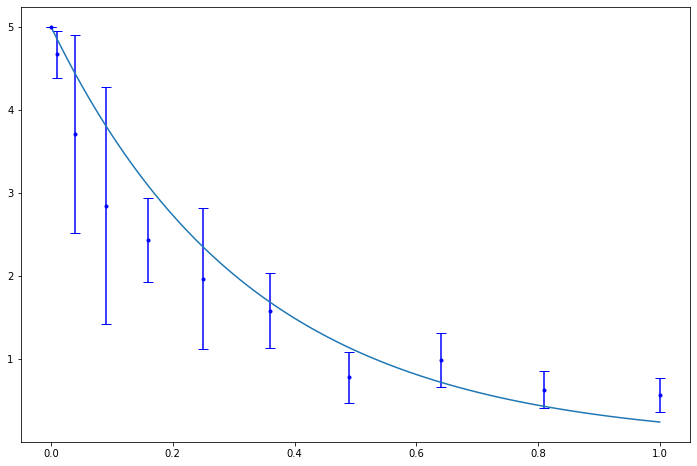

In [24]:
xplot = np.linspace(0, 1, 101)
plt.figure(figsize = (12, 8))
plt.errorbar(pts, dist_0, std_0, fmt = '.', c = 'b', capsize = 5)
plt.plot(xplot, f_model_exp(xplot, *exp_popt0))

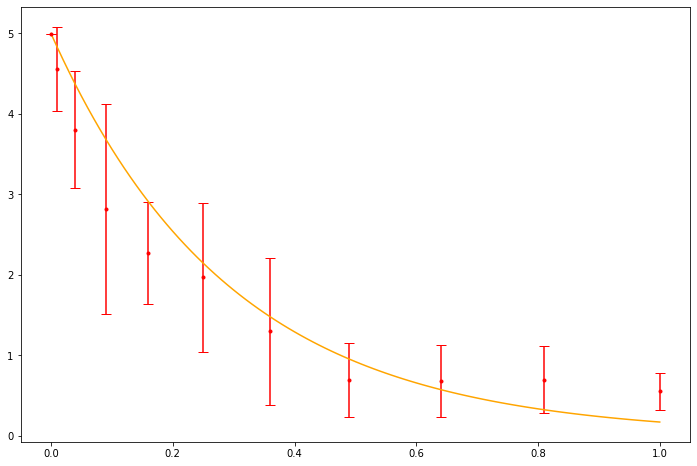

In [26]:
xplot = np.linspace(0, 1, 101)
plt.figure(figsize = (12, 8))
plt.errorbar(pts, dist_1, std_1, fmt = '.', c = 'r', capsize = 5)
plt.plot(xplot, f_model_exp(xplot, *exp_popt1), c = 'orange')

In [28]:
# Compute the predicted values using the fitted model for both popt0 and popt1
predicted_values_0 = f_model_exp(pts, *exp_popt0)
predicted_values_1 = f_model_exp(pts, *exp_popt1)

# Compute the residuals
residuals_0 = dist_0 - predicted_values_0
residuals_1 = dist_1 - predicted_values_1

# Square the residuals
squared_residuals_0 = residuals_0 ** 2
squared_residuals_1 = residuals_1 ** 2

# Compute the sum of squared residuals
sum_squared_residuals_0 = np.sum(squared_residuals_0)
sum_squared_residuals_1 = np.sum(squared_residuals_1)

print("Sum of squared residuals for K = -0.1:", sum_squared_residuals_0)
print("Sum of squared residuals for K = -1.0:", sum_squared_residuals_1)

Sum of squared residuals for K = -0.1: 2.394095458110525
Sum of squared residuals for K = -1.0: 1.9797258026032933


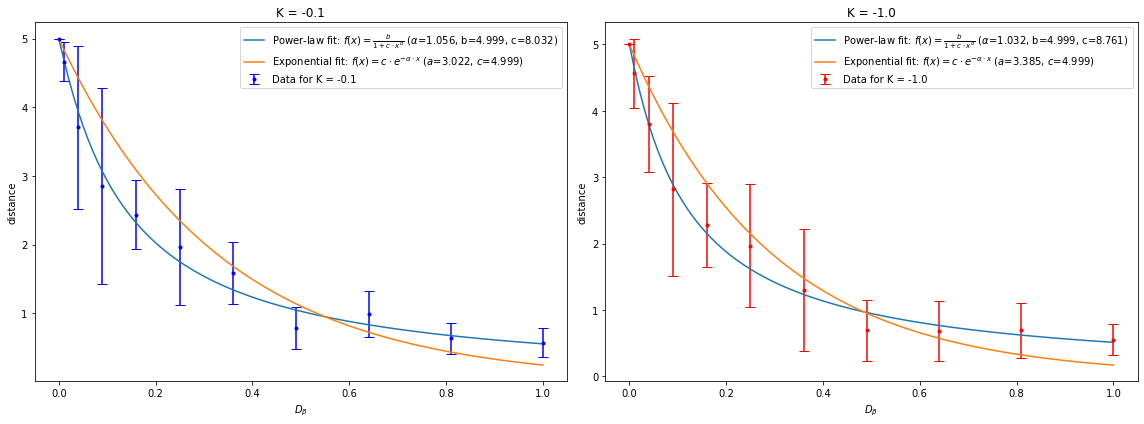

In [29]:
exp_popt0, exp_pcov0 = curve_fit(f_model_exp, pts, dist_0, sigma = std_0)
exp_popt1, exp_pcov1 = curve_fit(f_model_exp, pts, dist_1, sigma = std_1)


curve_label0 = r'Power-law fit: $f(x) = \frac{b}{1 + c \cdot x^\alpha}$' + f' ($\\alpha$={popt0[0]:.3f}, b={popt0[1]:.3f}, c={popt0[2]:.3f})'
curve_label1 = r'Power-law fit: $f(x) = \frac{b}{1 + c \cdot x^\alpha}$' + f' ($\\alpha$={popt1[0]:.3f}, b={popt1[1]:.3f}, c={popt1[2]:.3f})'

exp_curve_label0 = r'Exponential fit: $f(x) = c \cdot e^{- \alpha \cdot x}$' + f' ($a$={exp_popt0[0]:.3f}, $c$={exp_popt0[1]:.3f})'
exp_curve_label1 = r'Exponential fit: $f(x) = c \cdot e^{- \alpha \cdot x}$' + f' ($a$={exp_popt1[0]:.3f}, $c$={exp_popt1[1]:.3f})'

fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot for K = -0.1
axs[0].errorbar(pts, dist_0, std_0, fmt='.', c='b', capsize=5, label='Data for K = -0.1')
axs[0].plot(xplot, f_model_hyper(xplot, *popt0), label=curve_label0)
axs[0].plot(xplot, f_model_exp(xplot, *exp_popt0), label=exp_curve_label0)
axs[0].set_xlabel(r'$D_\beta$')
axs[0].set_ylabel('distance')
axs[0].set_title('K = -0.1')
axs[0].legend(loc='best')

# Plot for K = 1
axs[1].errorbar(pts, dist_1, std_1, fmt='.', c='r', capsize=5, label='Data for K = -1.0')
axs[1].plot(xplot, f_model_hyper(xplot, *popt1), label=curve_label1)
axs[1].plot(xplot, f_model_exp(xplot, *exp_popt1), label=exp_curve_label1)
axs[1].set_xlabel(r'$D_\beta$')
axs[1].set_ylabel('distance')
axs[1].set_title('K = -1.0')
axs[1].legend(loc='best')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Second power-law model

In [31]:
def f_model_hyper2(x, alpha, b):  # function to fit

    # Check if x is close to zero and avoid division by zero
    epsilon = 1e-6  # A small positive value to avoid division by zero
    x = np.where(np.abs(x) < epsilon, epsilon, x)
    
    return b/(1 + x)**alpha
    #return c*np.exp(-alpha*x)


popt0, pcov0 = curve_fit(f_model_hyper2, pts, dist_0, sigma = std_0, maxfev = 100000)
popt1, pcov1 = curve_fit(f_model_hyper2, pts, dist_1, sigma = std_1, maxfev = 100000)
print(popt0)
print(popt1)

[3.78093054 4.99882408]
[4.09307964 4.99882652]


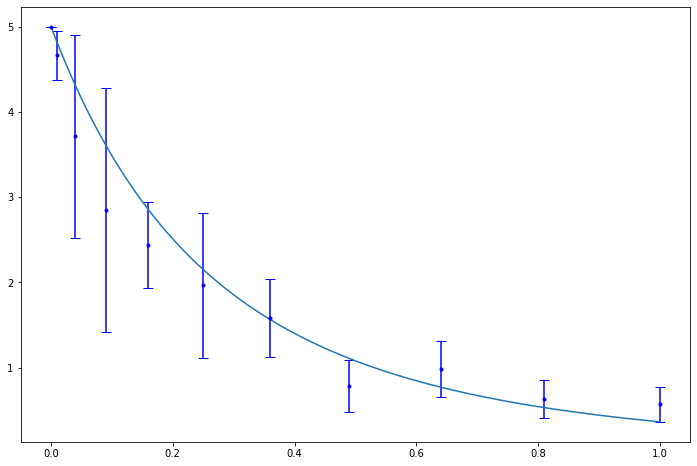

In [32]:
xplot = np.linspace(0, 1, 101)
plt.figure(figsize = (12, 8))
plt.errorbar(pts, dist_0, std_0, fmt = '.', c = 'b', capsize = 5)
plt.plot(xplot, f_model_hyper2(xplot, *popt0))

In [33]:
# Compute the predicted values using the fitted model for both popt0 and popt1
predicted_values_0 = f_model_hyper2(pts, *popt0)
predicted_values_1 = f_model_hyper2(pts, *popt1)

# Compute the residuals
residuals_0 = dist_0 - predicted_values_0
residuals_1 = dist_1 - predicted_values_1

# Square the residuals
squared_residuals_0 = residuals_0 ** 2
squared_residuals_1 = residuals_1 ** 2

# Compute the sum of squared residuals
sum_squared_residuals_0 = np.sum(squared_residuals_0)
sum_squared_residuals_1 = np.sum(squared_residuals_1)

print("Sum of squared residuals for K = -0.1:", sum_squared_residuals_0)
print("Sum of squared residuals for K = -1.0:", sum_squared_residuals_1)

Sum of squared residuals for K = -0.1: 1.3755808886883174
Sum of squared residuals for K = -1.0: 1.1822423596087248


# Other things

In [ ]:
stacked_objects = np.empty((0, 5))

# initial conditions
x0 = np.random.uniform(-2, 2, size = (params['N'], 2))
theta0 = np.random.uniform(-np.pi, np.pi, size = (params['N'], 1))
omega = stats.cauchy.rvs(scale=params['sigma'], size = params['N'])
params['omega'] = omega
beta0 = np.random.uniform(-np.pi, np.pi, size = (params['N'], 1))
X0 = np.concatenate([x0, theta0, beta0], axis = 1)
    
pos_0 = X0[:, :2]
cm_0 = np.mean(pos_0, axis=0)
    
t = params['n_iter'] - 1

for Dbeta in pts:
    
    params['Dbeta'] = Dbeta
    
    if not LOAD: 
        trial = generate_data_heun(X0, params)
        trial = np.stack(trial)        
    else:
        
        trial = np.load(folder_npy+"J={}_K={}_N={}_Db={}_dt={}_T={}".format(params['J'], params['K'], params['N'], params['Dbeta'], params['dt'], params['T'])+flag+"_aligned_final.npy")
    
    if SAVE_NP:
        np.save(folder_npy+"J={}_K={}_N={}_Db={}_dt={}_T={}".format(params['J'], params['K'], params['N'], params['Dbeta'], params['dt'], params['T'])+flag+"_aligned_initial.npy",
            trial[t])
        np.save(folder_npy+"J={}_K={}_N={}_Db={}_dt={}_T={}".format(params['J'], params['K'], params['N'], params['Dbeta'], params['dt'], params['T'])+flag+"_aligned_final.npy",
            trial[t])
    
    pos_f = trial[t][:, :2]
    cm_f = np.mean(pos_f, axis=0)
    norm_cm = np.linalg.norm(cm_f - cm_0)
    cm_d = np.hstack((cm_f, cm_0, norm_cm))
    stacked_objects = np.vstack((stacked_objects, cm_d))

In [ ]:
print(stacked_objects)

In [ ]:
plt.figure(figsize=(10, 8))
x_values = np.linspace(0, 1, num_points)
pts = (x_values) ** power
plt.scatter(pts, stacked_objects[:, 4])

In [ ]:
print(stacked_objects[:, 4])